In [ ]:
# Imports
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
# Crimmins Filter
def crimmins_filter(img, iterations=2):
    img = img.astype(np.int16)
    for _ in range(iterations):
        for offset in [(0, 1), (1, 0), (1, 1), (-1, 1)]:
            for direction in [+1, -1]:
                filtered = img.copy()
                for y in range(1, img.shape[0] - 1):
                    for x in range(1, img.shape[1] - 1):
                        neigh = img[y + offset[1], x + offset[0]]
                        if direction * (img[y, x] - neigh) >= 2:
                            filtered[y, x] -= direction
                img = filtered
    return np.clip(img, 0, 255).astype(np.uint8)

In [ ]:
# Manual Cropping to Square
def manual_crop(image, y1, y2, x1, x2, output_size=(224, 224)):
    cropped = image[y1:y2, x1:x2]
    return cv2.resize(cropped, output_size, interpolation=cv2.INTER_AREA)

In [ ]:
# Kidney Isolation + Inpainting
def isolate_kidneys(image, max_components=2):
    _, thresh = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=8)
    sorted_labels = sorted(range(1, num_labels), key=lambda i: stats[i, cv2.CC_STAT_AREA], reverse=True)
    mask = np.zeros_like(image, dtype=np.uint8)
    for i in sorted_labels[:max_components]:
        mask[labels == i] = 255
    inverse_mask = cv2.bitwise_not(mask)
    inpainted = cv2.inpaint(image, inverse_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted

In [ ]:
# Processing Pipeline
def process_image(image_path, crop_box=(20, 220, 20, 220), output_size=(224, 224)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    y1, y2, x1, x2 = crop_box
    cropped = manual_crop(image, y1, y2, x1, x2, output_size=output_size)
    kidneys_only = isolate_kidneys(cropped)
    denoised = crimmins_filter(kidneys_only)
    return denoised

In [ ]:
# Apply to Dataset
input_dir = r'.\data\raw'
output_dir = r'.\data\processed'
os.makedirs(output_dir, exist_ok=True)

for label in ['normal', 'pathological']:
    in_dir = os.path.join(input_dir, label)
    out_dir = os.path.join(output_dir, label)
    os.makedirs(out_dir, exist_ok=True)

    for fname in tqdm(os.listdir(in_dir), desc=f"Processing {label}"):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            fpath = os.path.join(in_dir, fname)
            processed = process_image(fpath)
            if processed is not None:
                out_path = os.path.join(out_dir, fname)
                cv2.imwrite(out_path, processed)

Processing pathological: 100%|██████████| 349/349 [04:15<00:00,  1.37it/s]


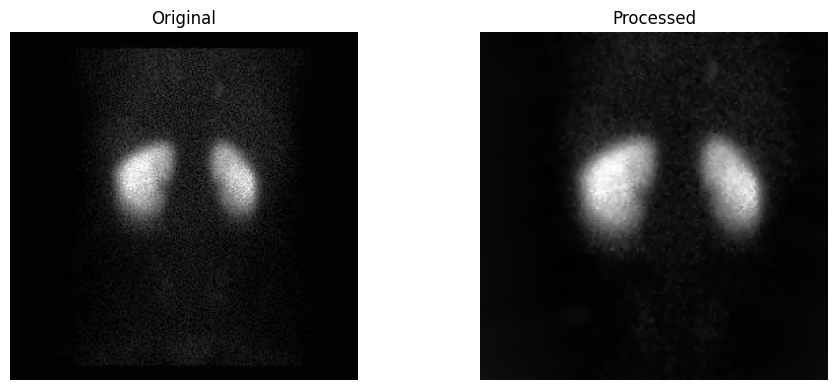

In [ ]:
# Visualize Before and After (optional)
def preview_image_pair(original_path):
    original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
    processed = process_image(original_path)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap='gray')
    plt.title("Processed")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example:
preview_image_pair(r".\data\raw\pathological\001.jpg")